In [3]:
""" 
Title: Eating disorders Montecatini 
Author: Corrado Caudek
Description: Check effect of medication (0 = absent, 1 = present) on HDDMRL parameters.
Version History:
- v1.0 (July 13, 2023): Initial version
Contact: corrado.caudek@unifi.it
"""


# Virtual environment: py37_env

import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-07-13 13:12:15


This notebook follows the [tutorial](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#checking-results) on the hddm webpage.


In [4]:
%matplotlib inline 

import os, time, csv, sys
import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

import pymc
import pymc as pm
import hddm
import kabuki
import arviz as az

import pymc.progressbar as pbar
import pathlib

from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin

from patsy import dmatrix  # for generation of (regression) design matrices
import pickle

from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

print(f"The hddm version is {hddm.__version__}")

The hddm version is 0.9.8


In [5]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

In [6]:
# Set display options to show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Reset display options to their default values
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [7]:
# custom save/load fns
def savePatch(self, fname):
    with open(fname, 'wb') as f:  # write binary
        pickle.dump(self, f)


hddm.HDDM.savePatch = savePatch


def load1(fname):
    model = pickle.load(open(fname, 'rb'))
    return model


hddm.load1 = load1


In [8]:
# custom fns (workaround) to compute posterior predictive checks for HDDM Regressor models
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node):  # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()
                   ) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]


def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            # Only modification of original Kabuki code
            sampled_data.reset_index(inplace=True)
            sampled_data = sampled_data.join(
                data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets


def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}
    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.ix[obs['node'].value.index])
                     for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue  # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(
            node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(
            datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])


In [9]:
pwd

'/Users/corrado/_repositories/eating_disorders_23/src/python/PRL/02_commorbidity'

Load data

In [10]:
data = hddm.load_csv(
    '/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/comorbidity/an_comorbidity.csv'
)

In [11]:
print('There are %d participants' % data['subj_idx'].nunique())

There are 36 participants


In [12]:
data["subj_code"].unique()

array(['ca_po_2002_05_25_700_f', 'em_or_2003_01_02_101_f',
       'au_ru_1998_09_21_806_f', 'ch_na_2007_06_23_908_f',
       'ch_ma_2001_10_27_332_f', 'bi_di_2006_04_20_725_f',
       'as_ga_2005_06_15_329_f', 'da_de_1998_08_15_141_m',
       'cl_pu_2007_05_24_423_f', 'gr_bo_1996_07_31_547_f',
       'fr_la_2004_05_17_363_f', 'ar_ce_2005_04_20_937_f',
       'fe_sa_2002_05_09_008_f', 'am_gu_1999_02_11_937_f',
       'be_ma_1999_06_15_475_f', 'fe_ma_1998_06_29_257_f',
       'ch_ri_1993_05_05_564_f', 'gi_za_1992_09_07_575_f',
       'ir_ve_2004_02_09_500_f', 'an_de_1998_11_10_289_f',
       'ma_va_1998_07_04_538_f', 'ir_pi_2002_01_22_765_f',
       'em_gr_2002_08_25_628_f', 'gi_ma_1999_09_26_585_f',
       'so_be_2008_12_15_399_f', 'ir_to_2007_08_01_838_f',
       'ch_ca_2000_09_26_406_f', 'em_al_1989_07_27_200_f',
       'ch_pi_2004_02_25_126_f', 'es_bo_2004_07_23_474_f',
       'em_bi_2007_12_28_766_f', 'cr_gi_1994_10_14_378_f',
       'ch_br_1993_10_04_623_f', 'he_ha_2006_04_21_874_f

In [13]:
data.groupby(["medication", "stim"]).agg({"feedback": "mean"})

feedback
medication stim             
0          food     0.547059
           neutral  0.557031
1          food     0.519118
           neutral  0.546691

In [14]:
data.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init,comorbidity,medication
0,1,0,food,0.979,1,0,0,AN,ca_po_2002_05_25_700_f,0.5,0,0
1,1,1,food,1.939,2,0,0,AN,ca_po_2002_05_25_700_f,0.5,0,0
2,1,0,food,0.768,3,0,0,AN,ca_po_2002_05_25_700_f,0.5,0,0
3,1,0,food,1.271,4,0,1,AN,ca_po_2002_05_25_700_f,0.5,0,0
4,1,1,food,1.929,5,0,1,AN,ca_po_2002_05_25_700_f,0.5,0,0


In [15]:
an_df = data[data['diag_cat'] == 'AN']
grouped_df = an_df.groupby('subj_code').agg({'medication': 'mean', 'comorbidity': 'mean'})
correlation = grouped_df['medication'].corr(grouped_df['comorbidity'])
print(correlation)


0.7826237921249265


In [16]:
count = data[data["medication"] == 1]["subj_code"].nunique()
print("Number of R-AN participants with medication:", count)

Number of R-AN participants with medication: 18


In [17]:
filtered_df = data[data["subj_idx"] != 25]

In [18]:
#####
# RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time
# alpha = learning rate from negative feedbacks
# pos_alpha = learning rate from positive feedbacks

mod = hddm.HDDMrl(
    filtered_df,
    # bias=True,
    depends_on={
        "a": ["medication", "stim"],
        "v": ["medication", "stim"],
        "t": ["medication", "stim"],
        "alpha": ["medication", "stim"],
        "pos_alpha": ["medication", "stim"],
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True,  # informative priors on ddm params
    include=["v", "a", "t"],
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [19]:
mod.find_starting_values()

/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [20]:
mod.sample(5000, burn=2000, dbname="models/ddm.db", db="pickle")

 [-----------------100%-----------------] 5001 of 5000 complete in 4058.6 sec

In [21]:
# get model traces 
grptrcs=mod.get_group_traces() # traces of all stochastic group nodes
alltrcs=mod.get_traces() # traces of all stochastic nodes

In [22]:
# export traces to .csv files (for later use in R)
# grptrcs.to_csv('ddm/ddm_grptrcs.csv')
# alltrcs.to_csv('ddm/ddm_alltrcs.csv')

In [23]:
print("mod DIC: %f" % mod.dic)

mod DIC: 12629.051622


Done saving traces (202206180603)

In [24]:
# get the individual node
subj_data = mod.get_subj_nodes()
subj_data.head()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init,comorbidity,medication,mean,std,2.5q,25q,50q,75q,97.5q,mc err,map
a_subj(0.food).1,a_subj,True,False,True,a_subj(0.food).1,"(0, food)","[medication, stim, subj_idx]",False,1,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.269584,0.058748,1.158359,1.228428,1.266798,1.309376,1.386845,0.00193,1.272967
a_subj(0.food).3,a_subj,True,False,True,a_subj(0.food).3,"(0, food)","[medication, stim, subj_idx]",False,3,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.537572,0.056714,1.431082,1.498571,1.537185,1.576942,1.650934,0.00147,1.494849
a_subj(0.food).4,a_subj,True,False,True,a_subj(0.food).4,"(0, food)","[medication, stim, subj_idx]",False,4,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.147435,0.048058,1.055822,1.113319,1.146294,1.181121,1.24141,0.001268,1.178572
a_subj(0.food).5,a_subj,True,False,True,a_subj(0.food).5,"(0, food)","[medication, stim, subj_idx]",False,5,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.641401,0.061001,1.527481,1.599363,1.639474,1.683189,1.761346,0.001422,1.580219
a_subj(0.food).6,a_subj,True,False,True,a_subj(0.food).6,"(0, food)","[medication, stim, subj_idx]",False,6,NaN,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.520242,0.063536,1.402674,1.474796,1.51787,1.564567,1.645634,0.001716,1.503569


In [47]:
alpha_nc_f, alpha_nc_n, alpha_c_f, alpha_c_n = mod.nodes_db.node[
    [
        "alpha(0.food)",
        "alpha(0.neutral)",
        "alpha(1.food)",
        "alpha(1.neutral)",
    ]
]

pos_alpha_nc_f, pos_alpha_nc_n, pos_alpha_c_f, pos_alpha_c_n = mod.nodes_db.node[
    [
        "pos_alpha(0.food)",
        "pos_alpha(0.neutral)",
        "pos_alpha(1.food)",
        "pos_alpha(1.neutral)",
    ]
]

Text(0.5, 1.0, 'Posterior of negative alpha group means\nDisorder-related context')

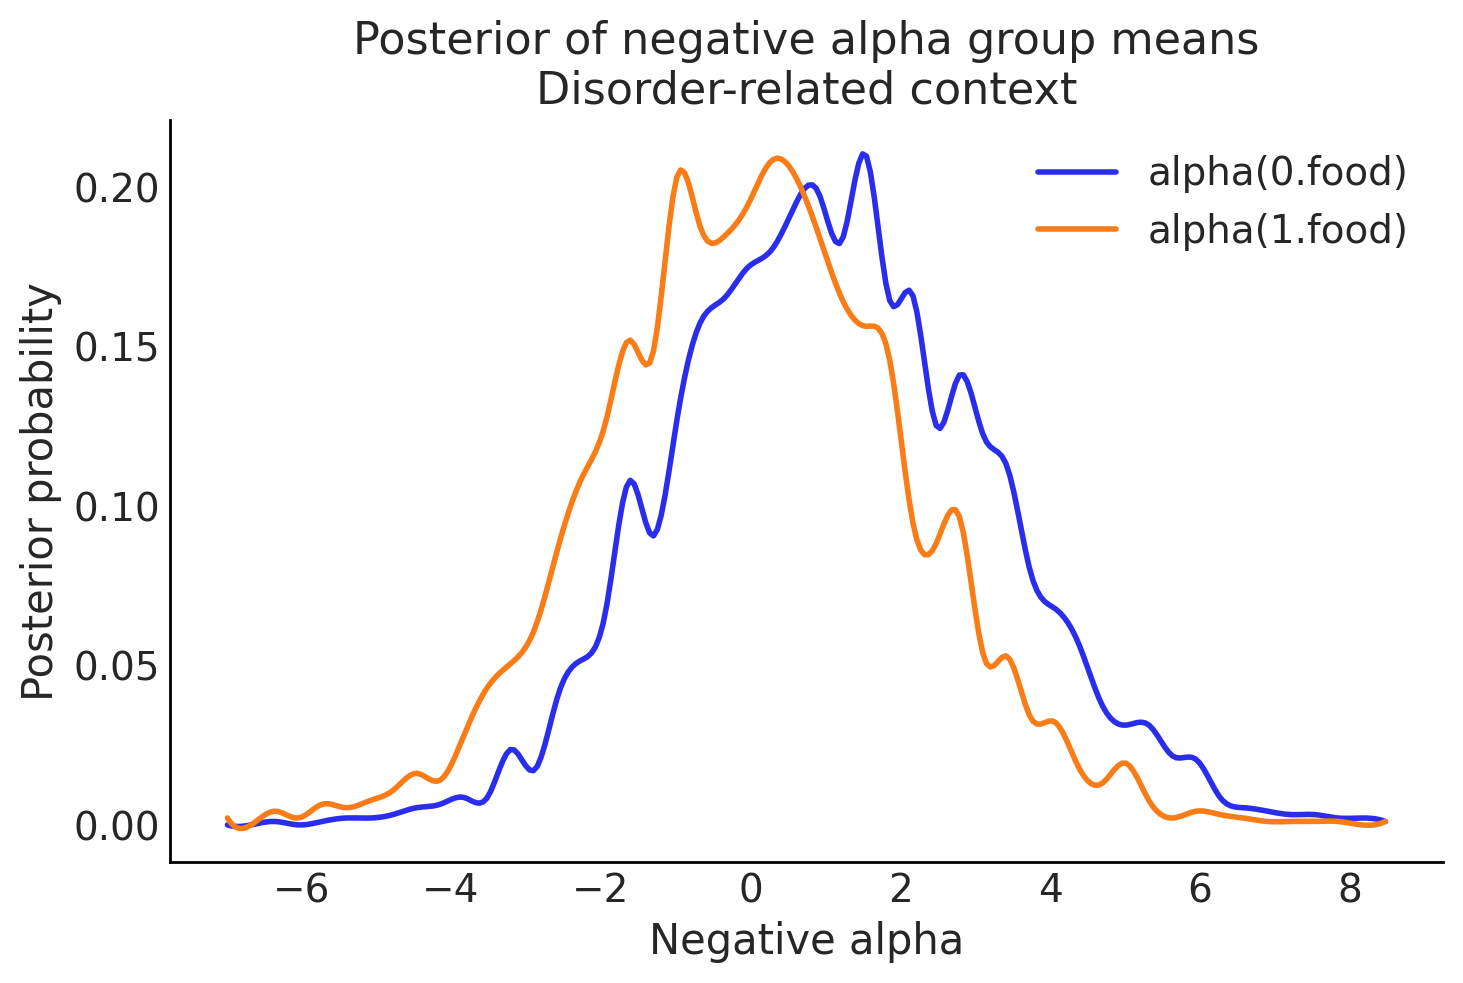

In [48]:
hddm.analyze.plot_posterior_nodes([alpha_nc_f, alpha_c_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means\nDisorder-related context')

Text(0.5, 1.0, 'Posterior of negative alpha group means\nDisorder-unrelated context')

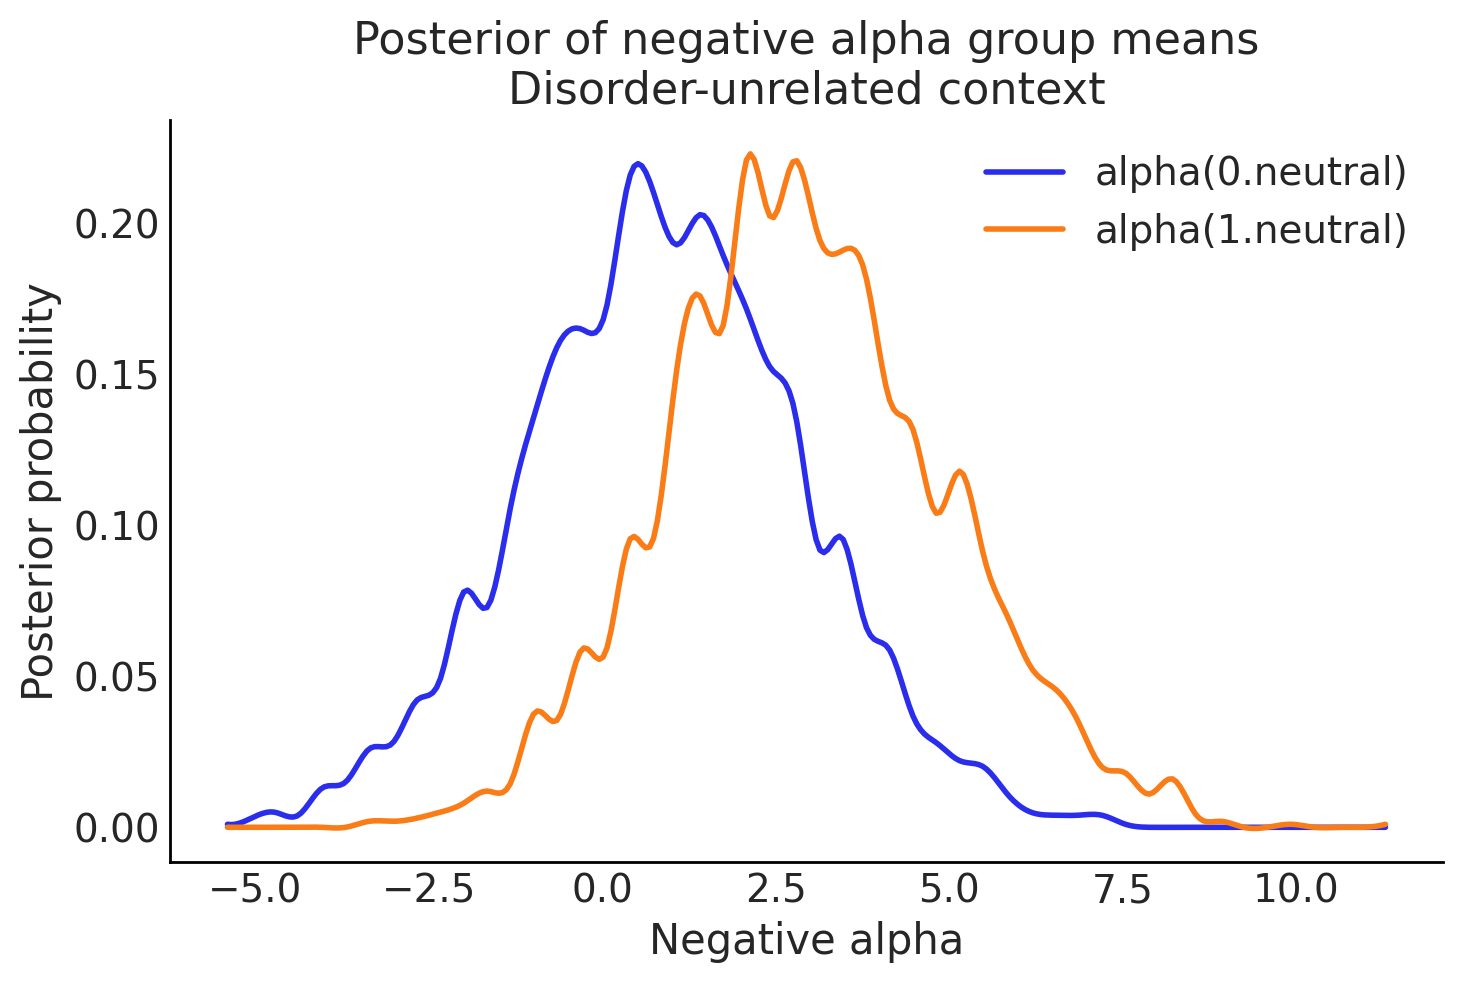

In [27]:
hddm.analyze.plot_posterior_nodes([alpha_nc_n, alpha_c_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means\nDisorder-unrelated context')

Text(0.5, 1.0, 'Posterior of positive alpha group means\nDisorder-related context')

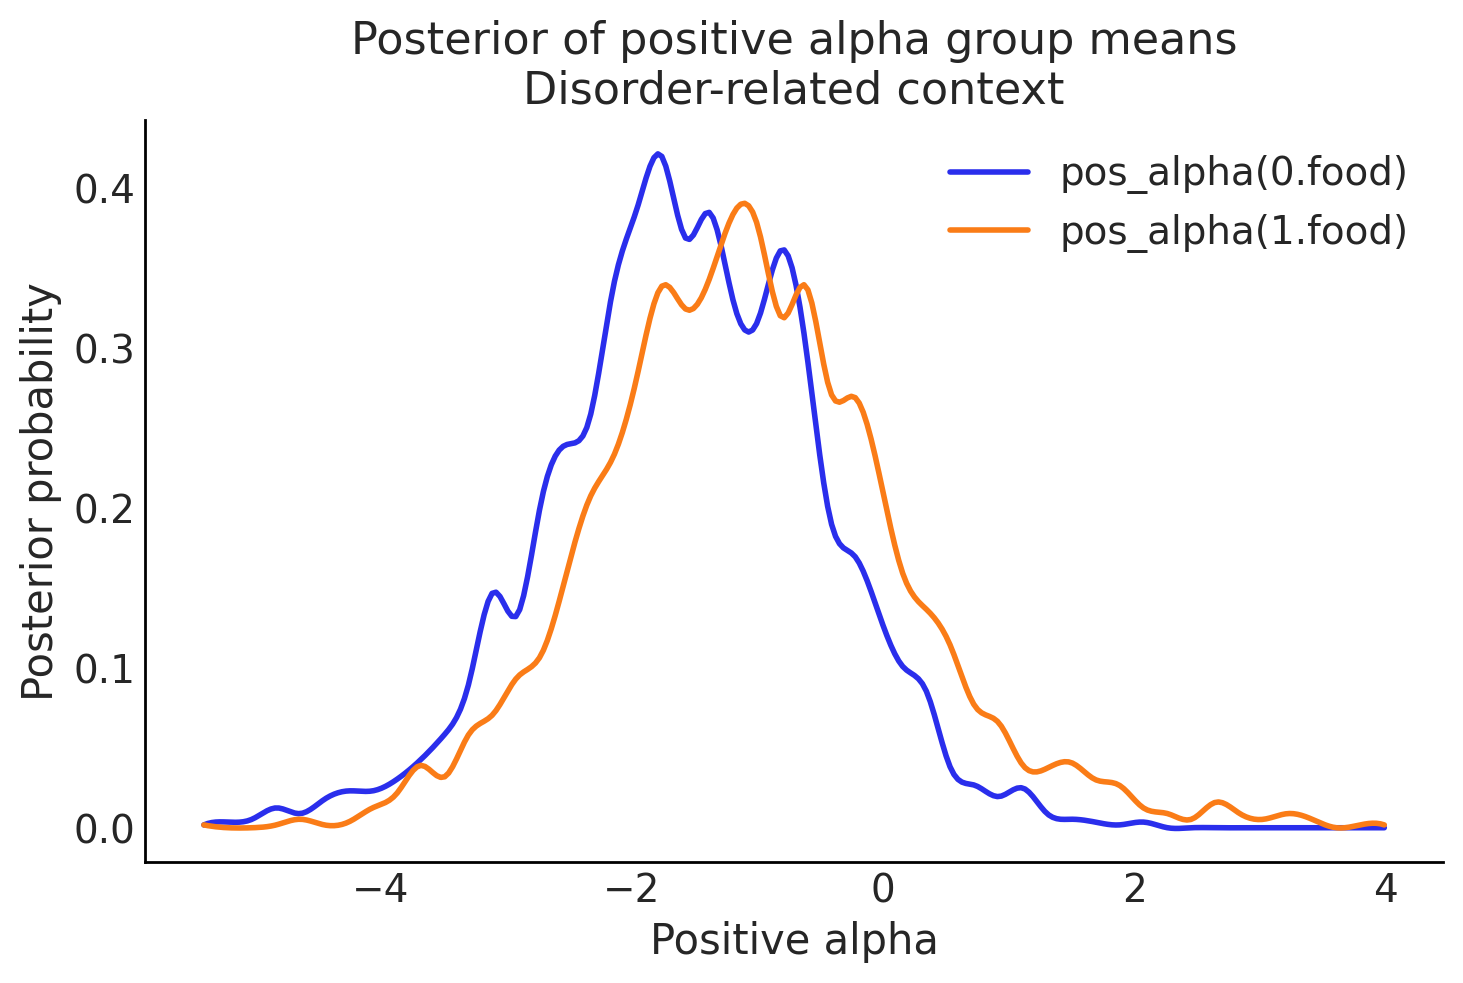

In [28]:
hddm.analyze.plot_posterior_nodes([pos_alpha_nc_f, pos_alpha_c_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means\nDisorder-related context')

Text(0.5, 1.0, 'Posterior of positive alpha group means\nDisorder-unrelated context')

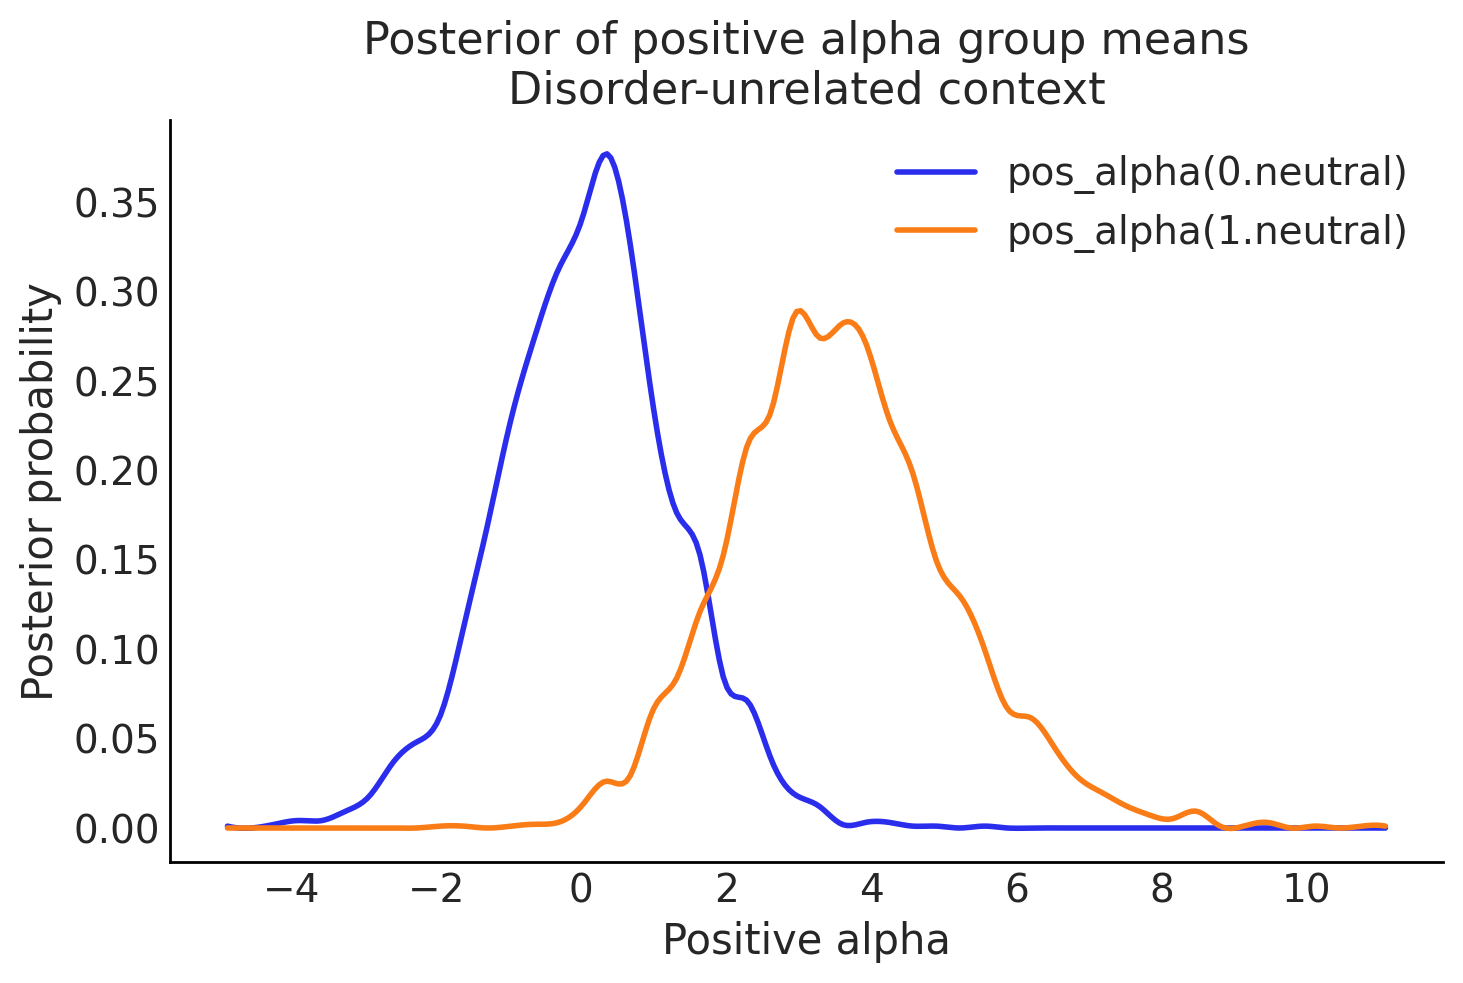

In [29]:
hddm.analyze.plot_posterior_nodes([pos_alpha_nc_n, pos_alpha_c_n])
plt.xlabel("Positive alpha")
plt.ylabel("Posterior probability")
plt.title("Posterior of positive alpha group means\nDisorder-unrelated context")

In [49]:
traces = mod.get_traces()
traces.head()


,a(0.food),a(0.neutral),a(1.food),a(1.neutral),a_std,a_subj(0.food).1,a_subj(0.food).3,a_subj(0.food).4,a_subj(0.food).5,a_subj(0.food).6,a_subj(0.food).9,a_subj(0.food).12,a_subj(0.food).15,a_subj(0.food).17,a_subj(0.food).18,a_subj(0.food).19,a_subj(0.food).21,a_subj(0.food).24,a_subj(0.food).26,a_subj(0.food).27,a_subj(0.food).30,a_subj(0.food).31,a_subj(0.neutral).1,a_subj(0.neutral).3,a_subj(0.neutral).4,a_subj(0.neutral).5,a_subj(0.neutral).6,a_subj(0.neutral).9,a_subj(0.neutral).12,a_subj(0.neutral).17,a_subj(0.neutral).18,a_subj(0.neutral).19,a_subj(0.neutral).24,a_subj(0.neutral).26,a_subj(0.neutral).27,a_subj(0.neutral).30,a_subj(0.neutral).31,a_subj(0.neutral).36,a_subj(1.food).2,a_subj(1.food).7,a_subj(1.food).8,a_subj(1.food).10,a_subj(1.food).11,a_subj(1.food).13,a_subj(1.food).14,a_subj(1.food).16,a_subj(1.food).20,a_subj(1.food).22,a_subj(1.food).23,a_subj(1.food).28,a_subj(1.food).29,a_subj(1.food).32,a_subj(1.food).33,a_subj(1.food).34,a_subj(1.neutral).2,a_subj(1.neutral).7,a_subj(1.neutral).8,a_subj(1.neutral).10,a_subj(1.neutral).11,a_subj(1.neutral).13,a_subj(1.neutral).14,a_subj(1.neutral).16,a_subj(1.neutral).20,a_subj(1.neutral).22,a_subj(1.neutral).23,a_subj(1.neutral).28,a_subj(1.neutral).29,a_subj(1.neutral).32,a_subj(1.neutral).34,a_subj(1.neutral).35,v(0.food),v(0.neutral),v(1.food),v(1.neutral),v_std,v_subj(0.food).1,v_subj(0.food).3,v_subj(0.food).4,v_subj(0.food).5,v_subj(0.food).6,v_subj(0.food).9,v_subj(0.food).12,v_subj(0.food).15,v_subj(0.food).17,v_subj(0.food).18,v_subj(0.food).19,v_subj(0.food).21,v_subj(0.food).24,v_subj(0.food).26,v_subj(0.food).27,v_subj(0.food).30,v_subj(0.food).31,v_subj(0.neutral).1,v_subj(0.neutral).3,v_subj(0.neutral).4,v_subj(0.neutral).5,v_subj(0.neutral).6,v_subj(0.neutral).9,v_subj(0.neutral).12,v_subj(0.neutral).17,v_subj(0.neutral).18,v_subj(0.neutral).19,v_subj(0.neutral).24,v_subj(0.neutral).26,v_subj(0.neutral).27,v_subj(0.neutral).30,v_subj(0.neutral).31,v_subj(0.neutral).36,v_subj(1.food).2,v_subj(1.food).7,v_subj(1.food).8,v_subj(1.food).10,v_subj(1.food).11,v_subj(1.food).13,v_subj(1.food).14,v_subj(1.food).16,v_subj(1.food).20,v_subj(1.food).22,v_subj(1.food).23,v_subj(1.food).28,v_subj(1.food).29,v_subj(1.food).32,v_subj(1.food).33,v_subj(1.food).34,v_subj(1.neutral).2,v_subj(1.neutral).7,v_subj(1.neutral).8,v_subj(1.neutral).10,v_subj(1.neutral).11,v_subj(1.neutral).13,v_subj(1.neutral).14,v_subj(1.neutral).16,v_subj(1.neutral).20,v_subj(1.neutral).22,v_subj(1.neutral).23,v_subj(1.neutral).28,v_subj(1.neutral).29,v_subj(1.neutral).32,v_subj(1.neutral).34,v_subj(1.neutral).35,t(0.food),t(0.neutral),t(1.food),t(1.neutral),t_std,t_subj(0.food).1,t_subj(0.food).3,t_subj(0.food).4,t_subj(0.food).5,t_subj(0.food).6,t_subj(0.food).9,t_subj(0.food).12,t_subj(0.food).15,t_subj(0.food).17,t_subj(0.food).18,t_subj(0.food).19,t_subj(0.food).21,t_subj(0.food).24,t_subj(0.food).26,t_subj(0.food).27,t_subj(0.food).30,t_subj(0.food).31,t_subj(0.neutral).1,t_subj(0.neutral).3,t_subj(0.neutral).4,t_subj(0.neutral).5,t_subj(0.neutral).6,t_subj(0.neutral).9,t_subj(0.neutral).12,t_subj(0.neutral).17,t_subj(0.neutral).18,t_subj(0.neutral).19,t_subj(0.neutral).24,t_subj(0.neutral).26,t_subj(0.neutral).27,t_subj(0.neutral).30,t_subj(0.neutral).31,t_subj(0.neutral).36,t_subj(1.food).2,t_subj(1.food).7,t_subj(1.food).8,t_subj(1.food).10,t_subj(1.food).11,t_subj(1.food).13,t_subj(1.food).14,t_subj(1.food).16,t_subj(1.food).20,t_subj(1.food).22,t_subj(1.food).23,t_subj(1.food).28,t_subj(1.food).29,t_subj(1.food).32,t_subj(1.food).33,t_subj(1.food).34,t_subj(1.neutral).2,t_subj(1.neutral).7,t_subj(1.neutral).8,t_subj(1.neutral).10,t_subj(1.neutral).11,t_subj(1.neutral).13,t_subj(1.neutral).14,t_subj(1.neutral).16,t_subj(1.neutral).20,t_subj(1.neutral).22,t_subj(1.neutral).23,t_subj(1.neutral).28,t_subj(1.neutral).29,t_subj(1.neutral).32,t_subj(1.neutral).34,t_subj(1.neutral).35,alpha(0.food),alpha(0.neutral),alpha(1.food),alpha(1.neutral),alpha_std,alpha_subj(0.food).1,alpha_

## Decision threshold

Parameter `a` as a function of comorbidity (0=absent; 1=present)

In [56]:
traces['score_diff'] = traces['a(0.food)'] - traces['a(1.food)']
quantiles = traces['score_diff'].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.233068
0.500   -0.074371
0.975    0.078040
Name: score_diff, dtype: float64

In [32]:
traces['score_diff'] = traces['a(0.neutral)'] - traces['a(1.neutral)']
quantiles = traces['score_diff'].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.208095
0.500   -0.056295
0.975    0.100487
Name: score_diff, dtype: float64

## Drift rate

Parameter `v` as a function of comorbidity (0=absent; 1=present)

In [33]:
traces["score_diff"] = traces["v(0.food)"] - traces["v(1.food)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.952105
0.500    0.370139
0.975    1.701322
Name: score_diff, dtype: float64

In [34]:
traces["score_diff"] = traces["v(0.neutral)"] - traces["v(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -0.360807
0.500    0.836855
0.975    2.031197
Name: score_diff, dtype: float64

## Non-decision time

Parameter `t` as a function of comorbidity (0=absent; 1=present)

In [35]:
traces["score_diff"] = traces["t(0.food)"] - traces["t(1.food)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
print(quantiles)

0.025   -0.047979
0.500    0.005000
0.975    0.059408
Name: score_diff, dtype: float64


In [36]:
traces["score_diff"] = traces["t(0.neutral)"] - traces["t(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
print(quantiles)

0.025   -0.065814
0.500   -0.007055
0.975    0.047036
Name: score_diff, dtype: float64


## Negative alpha 

Parameter `alpha` as function of comorbidity (0=absent; 1=present)

In [37]:
traces["score_diff"] = traces["alpha(0.food)"] - traces["alpha(1.food)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -4.505963
0.500    1.009643
0.975    6.468507
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-related context')

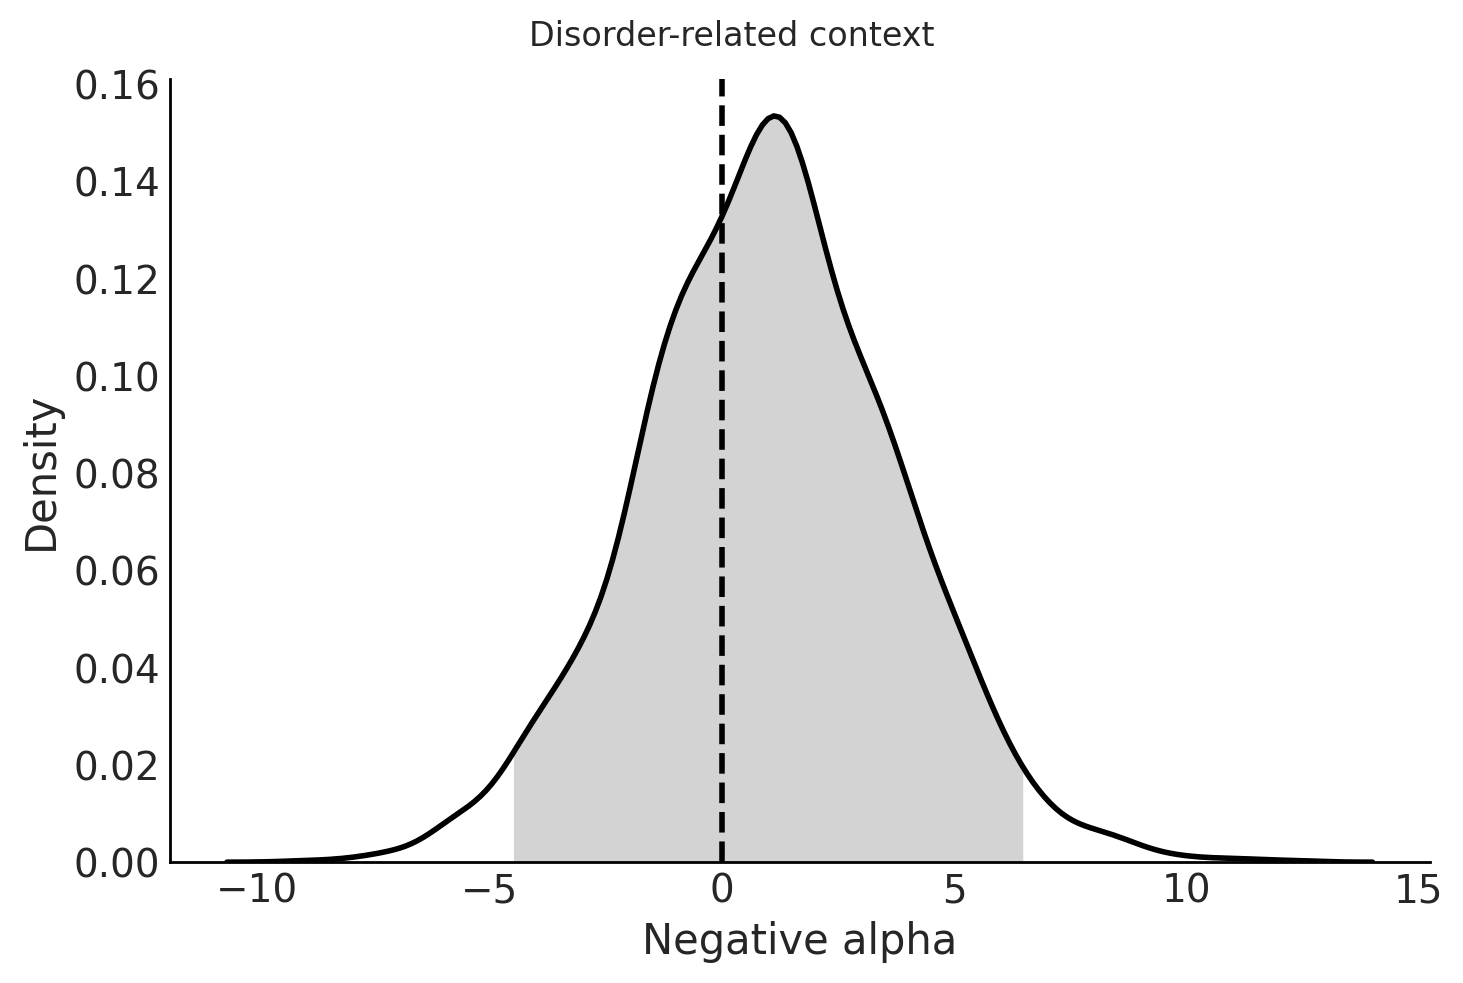

In [38]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Negative alpha")
sns_plot.figure.suptitle("Disorder-related context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

In [39]:
traces["score_diff"] = traces["alpha(0.neutral)"] - traces["alpha(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -7.674303
0.500   -1.843684
0.975    3.351235
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-unrelated context')

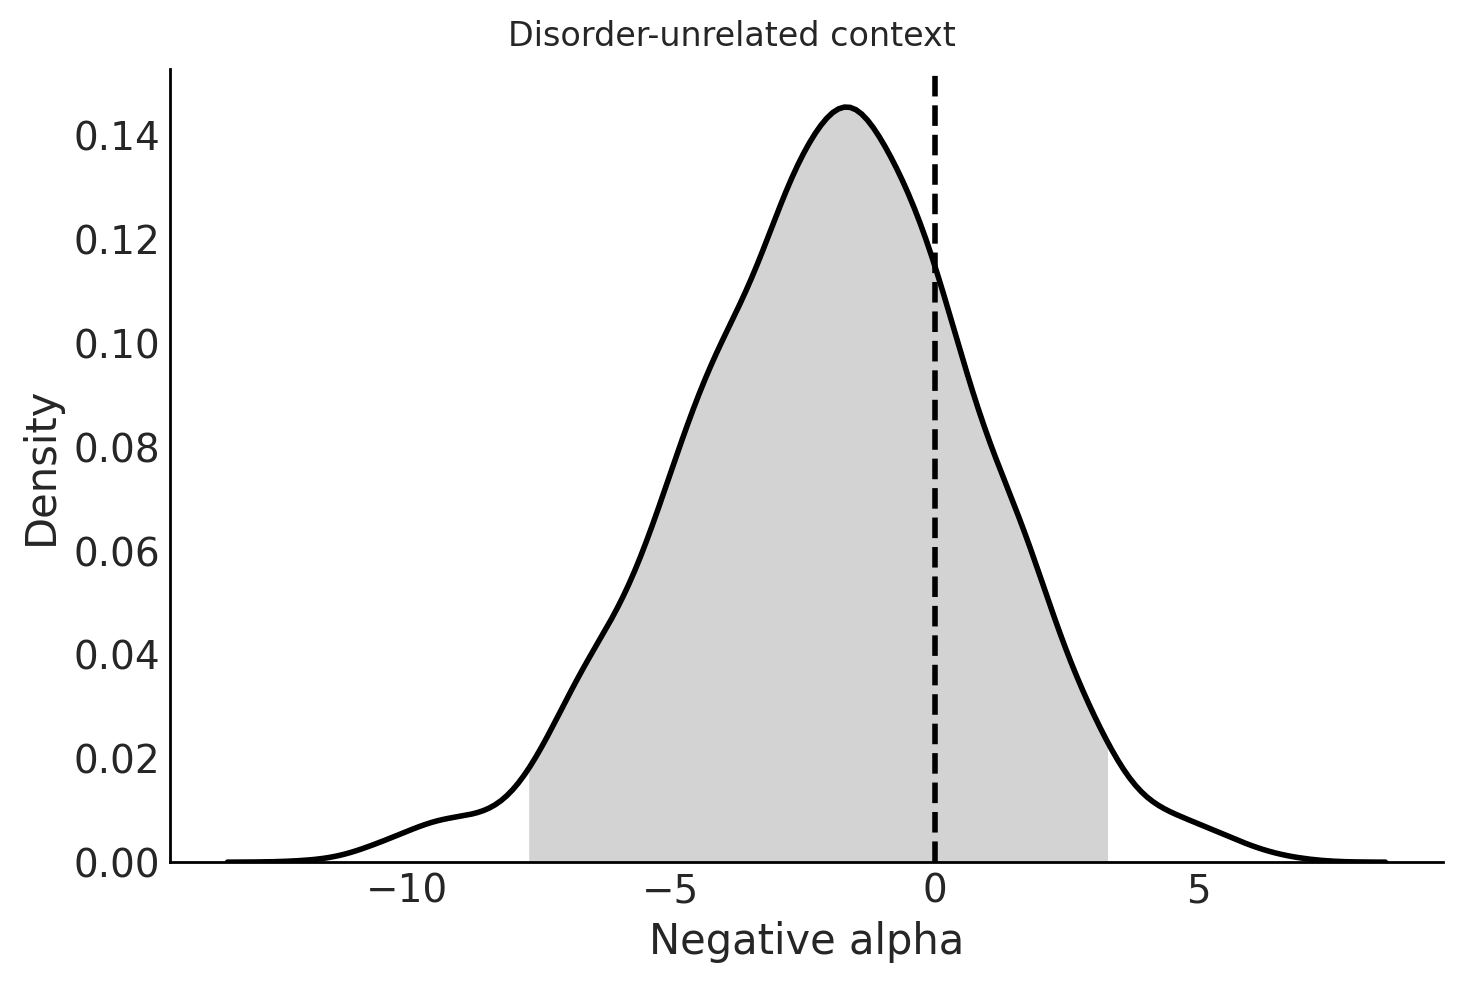

In [40]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Negative alpha")
sns_plot.figure.suptitle("Disorder-unrelated context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

## Positive alpha 

Parameter `pos_alpha` as function of comorbidity (0=absent; 1=present)

In [41]:
traces['score_diff'] = traces['pos_alpha(0.food)'] - traces['pos_alpha(1.food)']
quantiles = traces['score_diff'].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -3.704882
0.500   -0.440456
0.975    2.547583
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-related context')

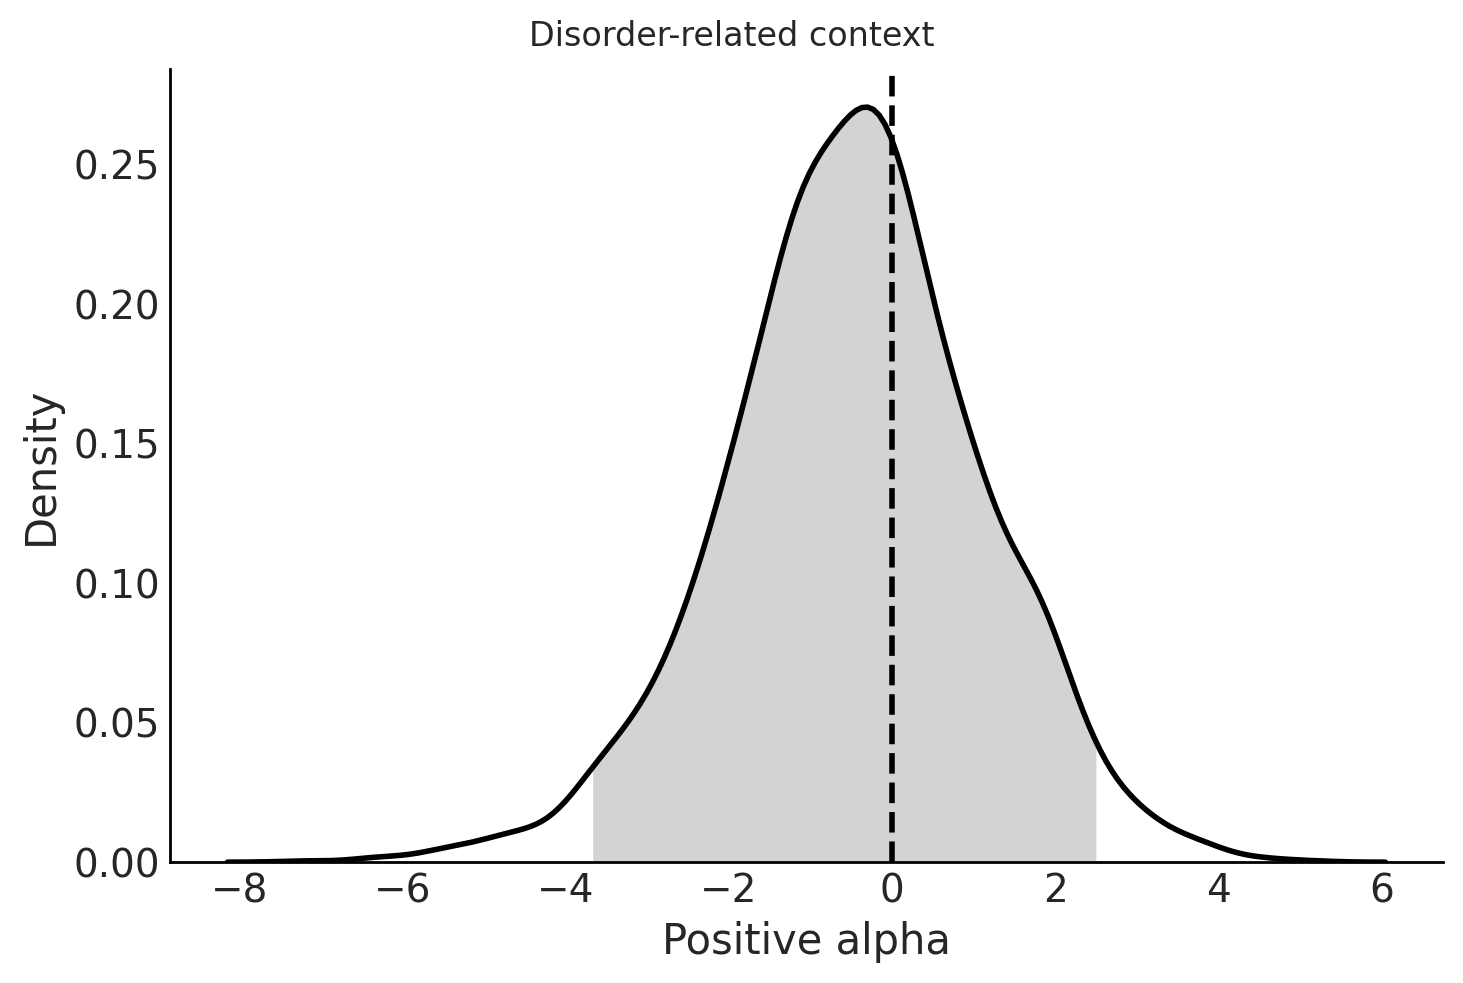

In [42]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Positive alpha")
sns_plot.figure.suptitle("Disorder-related context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

In [43]:
traces["score_diff"] = traces["pos_alpha(0.neutral)"] - traces["pos_alpha(1.neutral)"]
quantiles = traces["score_diff"].quantile([0.025, 0.5, 0.975])
quantiles

0.025   -7.474484
0.500   -3.345765
0.975    0.241252
Name: score_diff, dtype: float64

Text(0.5, 0.98, 'Disorder-unrelated context')

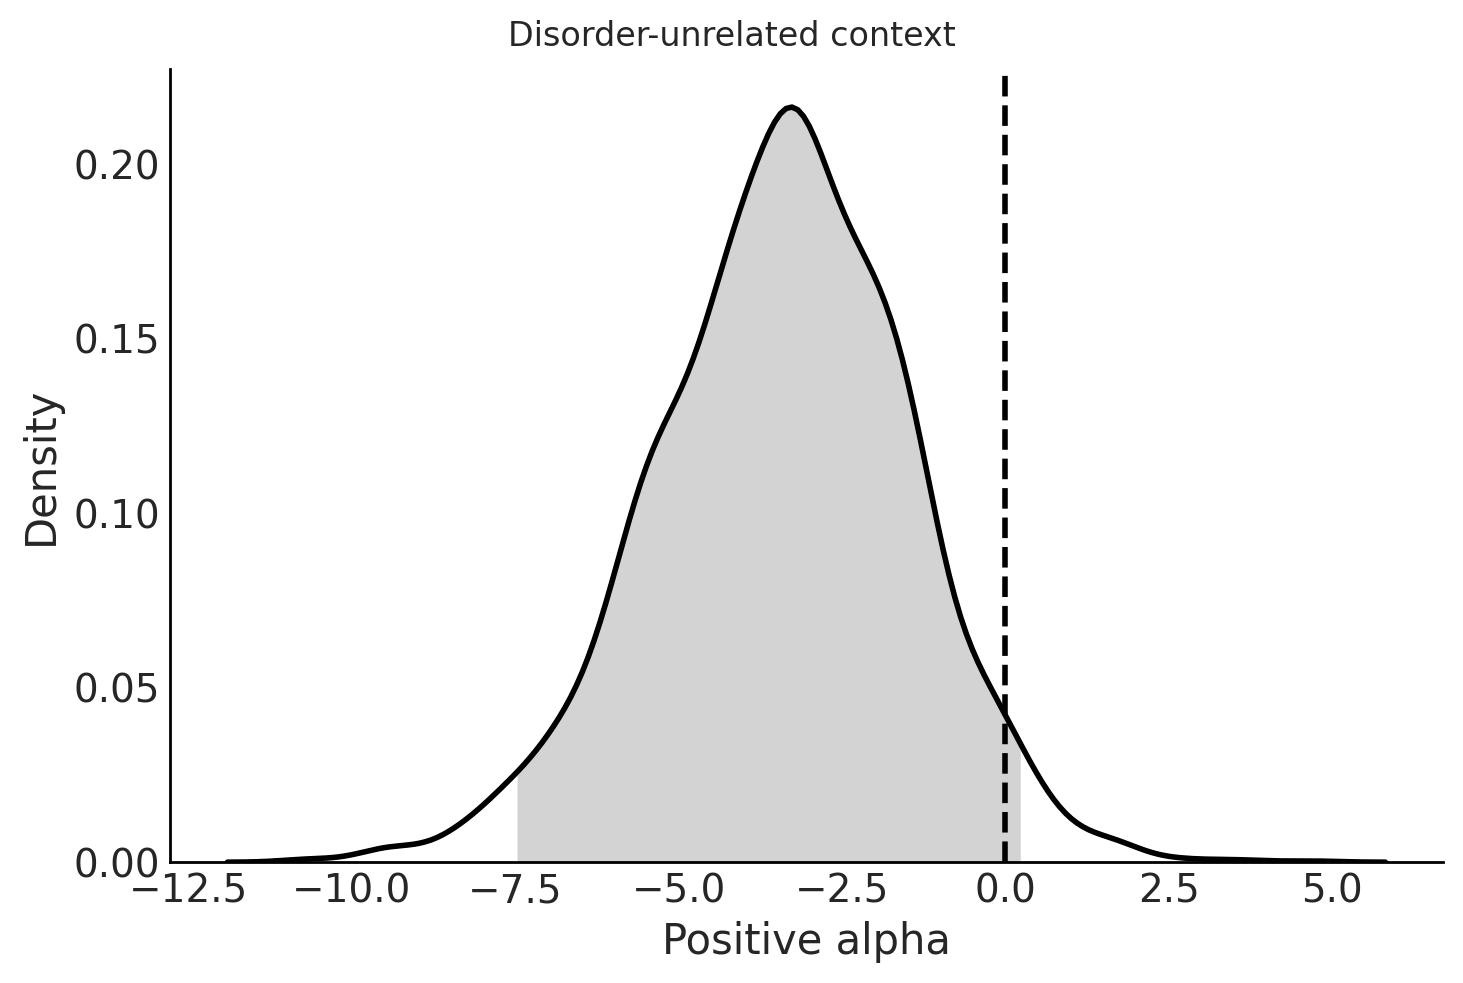

In [44]:
low, high = quantiles[0.025], quantiles[0.975]
sns_plot = sns.kdeplot(data=traces, x="score_diff")
line = sns_plot.lines[0]
x, y = line.get_data()
plt.plot(x, y, color="black", lw=2)
idx_delta = np.logical_and(x >= low, x <= high)
plt.fill_between(x, y, where=idx_delta, color="lightgray")
plt.axvline(0, color="black", linestyle="--", linewidth=2)
sns_plot.set_xlabel("Positive alpha")
sns_plot.figure.suptitle("Disorder-unrelated context")
# sns_plot.figure.savefig("an_neutral_pos_alpha.pdf")

# Print fitted parameters and other model statistics


In [57]:
mod.print_stats()

                                  mean       std       2.5q        25q       50q        75q      97.5q    mc err
a(0.food)                     1.415479  0.055608   1.310881   1.378359  1.415883   1.452163   1.524933  0.001403
a(0.neutral)                   1.26224  0.054411   1.154139   1.225449  1.261823   1.298176   1.368745  0.001006
a(1.food)                     1.490108  0.057434   1.379397   1.449805  1.490125   1.528957   1.606801  0.001279
a(1.neutral)                  1.317644  0.056883   1.203276   1.279779  1.317246   1.354388   1.437032  0.001227
a_std                         0.221771  0.024144   0.180785   0.204205  0.219868   0.236916   0.275053  0.000679
a_subj(0.food).1              1.269584  0.058748   1.158359   1.228428  1.266798   1.309376   1.386845   0.00193
a_subj(0.food).3              1.537572  0.056714   1.431082   1.498571  1.537185   1.576942   1.650934   0.00147
a_subj(0.food).4              1.147435  0.048058   1.055822   1.113319  1.146294   1.181121    1

## Checking results


### Estimate convergence


In [ ]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        filtered_df,
        # bias=True,
        depends_on={
            "a": ["diag_cat", "stim"],
            "v": ["diag_cat", "stim"],
            "t": ["diag_cat", "stim"],
            "alpha": ["diag_cat", "stim"],
            "pos_alpha": ["diag_cat", "stim"],
        },
        dual=True, 
        p_outlier=0.05,
        informative=True,  
        include=["v", "a", "t"],
    )
    m.sample(3000, burn=1000, dbname="traces.db", db="pickle")
    models.append(m)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 3000 of 3000 complete in 807.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 3001 of 3000 complete in 812.9 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 3001 of 3000 complete in 817.9 sec

In [ ]:
gel_rub = gelman_rubin(models)
print(gel_rub)

{'a(AN.food)': 0.9999564096167706, 'a(AN.neutral)': 1.000443520541336, 'a_std': 1.0007639783740907, 'a_subj(AN.food).1': 1.0028215838185321, 'a_subj(AN.food).2': 0.9998508697184092, 'a_subj(AN.food).3': 0.9998035500421516, 'a_subj(AN.food).4': 1.0001375308975662, 'a_subj(AN.food).5': 1.0013145849174696, 'a_subj(AN.food).6': 0.9997820545758542, 'a_subj(AN.food).7': 1.0009807793788685, 'a_subj(AN.food).8': 1.0000291197941462, 'a_subj(AN.food).9': 1.0000633915826795, 'a_subj(AN.food).10': 1.0025814347122093, 'a_subj(AN.food).11': 1.0002329893585882, 'a_subj(AN.food).12': 1.0006526879257251, 'a_subj(AN.food).13': 1.0000903675583765, 'a_subj(AN.food).14': 1.0011205494617206, 'a_subj(AN.food).15': 1.000909007384312, 'a_subj(AN.food).16': 1.0005673848917196, 'a_subj(AN.food).17': 1.0007153789577727, 'a_subj(AN.food).18': 1.000521050484729, 'a_subj(AN.food).19': 1.0027738427428763, 'a_subj(AN.food).20': 0.9998680962328527, 'a_subj(AN.food).21': 1.000188477278878, 'a_subj(AN.food).22': 1.000427

In [ ]:
np.max(list(gelman_rubin(models).values()))


1.0144526102417895

In [ ]:
np.mean(list(gelman_rubin(models).values()))


1.0012101596760707